## Bibliotheken

In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install -U xgboost


## Daten einlesen

In [2]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape)  
print(test.shape) 

(200000, 202)
(200000, 201)


In [3]:
print(train.columns)       
print(train.dtypes.value_counts()) 
print(train.head()) 

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)
float64    200
object       1
int64        1
Name: count, dtype: int64
   ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7

In [4]:
# wie viele Zeilen, haben den Targetvalue 0 (haben keine Transaktion durchgeführt) und wie viele 1 
counts = train['target'].value_counts()
print(train['target'].value_counts(normalize=True))


target
0    0.89951
1    0.10049
Name: proportion, dtype: float64


## Fehlende Werte

/var/folders/s1/r668xk3d7gx_3r_j4p759nrr0000gn/T/ipykernel_9609/2574789645.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="coolwarm")


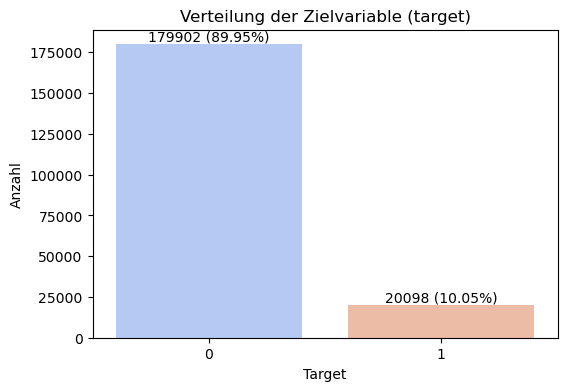

In [6]:
counts = train['target'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values, palette="coolwarm")

# Labels
plt.title("Verteilung der Zielvariable (target)")
plt.xlabel("Target")
plt.ylabel("Anzahl")

# Prozent auf den Balken
for i, val in enumerate(counts.values):
    plt.text(i, val + 2000, f"{val} ({val/len(train)*100:.2f}%)", ha='center')

plt.show()

Counts:
 target
0    179902
1     20098
Name: count, dtype: int64

Percents:
 target
0    0.8995
1    0.1005
Name: proportion, dtype: float64


/var/folders/s1/r668xk3d7gx_3r_j4p759nrr0000gn/T/ipykernel_9609/2876656759.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="coolwarm")


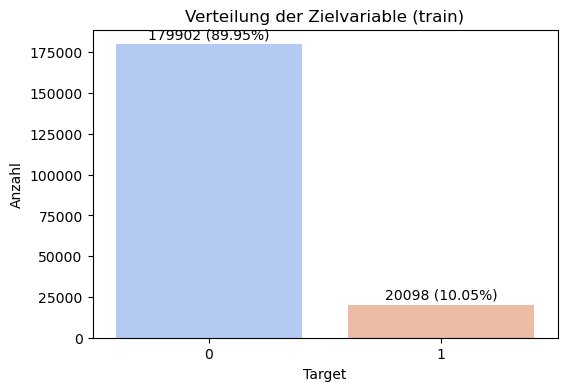

In [7]:
# 1) توزيع الهدف في كامل train (مثل كودك)
counts = train['target'].value_counts()
print("Counts:\n", counts)
print("\nPercents:\n", train['target'].value_counts(normalize=True).round(4))

plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values, palette="coolwarm")
plt.title("Verteilung der Zielvariable (train)")
plt.xlabel("Target"); plt.ylabel("Anzahl")
for i, val in enumerate(counts.values):
    plt.text(i, val + max(counts.values)*0.02, f"{val} ({val/len(train)*100:.2f}%)", ha='center')
plt.show()



ALL counts:
target
0    179902
1     20098
Name: count, dtype: int64
ALL percents (%):
target
0    89.95
1    10.05
Name: proportion, dtype: float64

TRAIN counts:
target
0    143922
1     16078
Name: count, dtype: int64
TRAIN percents (%):
target
0    89.95
1    10.05
Name: proportion, dtype: float64

VAL counts:
target
0    35980
1     4020
Name: count, dtype: int64
VAL percents (%):
target
0    89.95
1    10.05
Name: proportion, dtype: float64


/var/folders/s1/r668xk3d7gx_3r_j4p759nrr0000gn/T/ipykernel_8773/80282927.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=c.index, y=c.values, palette="coolwarm")


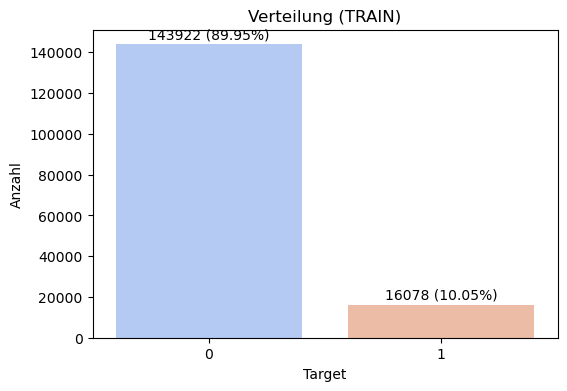

/var/folders/s1/r668xk3d7gx_3r_j4p759nrr0000gn/T/ipykernel_8773/80282927.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=c.index, y=c.values, palette="coolwarm")


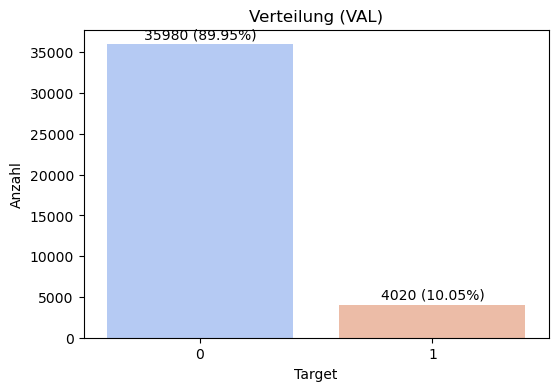

In [7]:
# 2) Stratified Train/Validation Split للحفاظ على نفس النِّسب
from sklearn.model_selection import train_test_split

X = train.drop(columns=['target'])
y = train['target']

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# تأكيد التوزيع
def show_dist(name, y_):
    c = y_.value_counts()
    p = (y_.value_counts(normalize=True)*100).round(2)
    print(f"\n{name} counts:\n{c}")
    print(f"{name} percents (%):\n{p}")

show_dist("ALL", y)
show_dist("TRAIN", y_tr)
show_dist("VAL", y_val)

# رسومات مثل أسلوبك
for title, y_ in [("TRAIN", y_tr), ("VAL", y_val)]:
    c = y_.value_counts().reindex(counts.index, fill_value=0)  # ترتيب نفس ترتيب الكلي
    plt.figure(figsize=(6,4))
    sns.barplot(x=c.index, y=c.values, palette="coolwarm")
    plt.title(f"Verteilung ({title})")
    plt.xlabel("Target"); plt.ylabel("Anzahl")
    for i, val in enumerate(c.values):
        plt.text(i, val + max(c.values)*0.02, f"{val} ({val/len(y_)*100:.2f}%)", ha='center')
    plt.show()


In [7]:
# Fehlende Werte 
print(train.isnull().sum().sum())  
print(test.isnull().sum().sum())


0
0


## konstante Features

In [8]:
# Gibt es konstante Features? die sind für uns unwichtig, weil sie keine neue Informationen bringen
nunique = train.drop(['ID_code', 'target'], axis=1).nunique()
constant_cols = nunique[nunique == 1].index.tolist()
print("Constant columns:", constant_cols)


Constant columns: []


In [9]:
train.drop(columns=constant_cols, inplace=True)
test.drop(columns=constant_cols, inplace=True)


## Speicherplatz Sparen 

In [10]:
train.dtypes


ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
            ...   
var_195    float64
var_196    float64
var_197    float64
var_198    float64
var_199    float64
Length: 202, dtype: object

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [11]:
float_cols = train.select_dtypes(include='float64').columns

info = pd.DataFrame({
    'min': train[float_cols].min(),
    'max': train[float_cols].max(),
    'mean': train[float_cols].mean(),
    'max_abs': train[float_cols].abs().max(),
    'decimals': train[float_cols].apply(lambda x: x.map(lambda y: len(str(y).split('.')[1]) if '.' in str(y) else 0).max())
})

print(info)


             min      max       mean  max_abs  decimals
var_0     0.4084  20.3150  10.679914  20.3150         4
var_1   -15.0434  10.3768  -1.627622  15.0434         4
var_2     2.1171  19.3530  10.715192  19.3530         4
var_3    -0.0402  13.1883   6.796529  13.1883         4
var_4     5.0748  16.6714  11.078333  16.6714         4
...          ...      ...        ...      ...       ...
var_195  -5.2610   4.2729  -0.142088   5.2610         4
var_196 -14.2096  18.3215   2.303335  18.3215         4
var_197   5.9606  12.0004   8.908158  12.0004         4
var_198   6.2993  26.0791  15.870720  26.0791         4
var_199 -38.8528  28.5007  -3.326537  38.8528         4

[200 rows x 5 columns]


In [12]:

float_cols = train.select_dtypes(include='float64').columns

# Zählt wie oft genau 4 Dezimalstellen vorkommen pro Spalte
decimal_count_4 = train[float_cols].apply(
    lambda col: col.map(
        lambda val: 1 if '.' in str(val) and len(str(val).split('.')[1]) == 4 else 0
    ).sum()
)

print(decimal_count_4)


var_0      180051
var_1      180122
var_2      179971
var_3      180041
var_4      179819
            ...  
var_195    179993
var_196    180059
var_197    179986
var_198    179824
var_199    180084
Length: 200, dtype: int64


In [13]:
# Funktion zur Speicherberechnung in MB
# Umwandlung von float 64 in Float 34 
def mem_mb(df):
    return df.memory_usage(deep=True).sum() / 1024**2

# 1) Float64-Spalten finden
float_cols = train.select_dtypes(include='float64').columns

print(f"Speicher vorher (train): {mem_mb(train):.2f} MB")
print(f"Speicher vorher (test) : {mem_mb(test):.2f} MB")

# 2) Umwandlung in float32
train[float_cols] = train[float_cols].astype('float32')
test[float_cols]  = test[float_cols].astype('float32')

print(f"Speicher nachher (train): {mem_mb(train):.2f} MB")
print(f"Speicher nachher (test) : {mem_mb(test):.2f} MB")


Speicher vorher (train): 318.23 MB
Speicher vorher (test) : 316.51 MB
Speicher nachher (train): 165.64 MB
Speicher nachher (test) : 163.93 MB


In [14]:
# Vorher Speicherverbrauch prüfen
print("Vorher:", train['target'].memory_usage(deep=True), "Bytes")

# Umwandlung in int8
train['target'] = train['target'].astype('int8')

# Nachher Speicherverbrauch prüfen
print("Nachher:", train['target'].memory_usage(deep=True), "Bytes")


Vorher: 1600132 Bytes
Nachher: 200132 Bytes


In [15]:
# Umwandlung von Object in String 

train["ID_code"] = train["ID_code"].astype("string")

## Duplikate entfernen

In [16]:
def get_duplicate_columns(df):
    duplicates = set()
    cols = df.columns
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            if df[cols[i]].equals(df[cols[j]]):
                duplicates.add(cols[j])
    return list(duplicates)

dup_cols = get_duplicate_columns(train.drop(['ID_code', 'target'], axis=1))
print("Duplicated columns:", dup_cols)

train.drop(columns=dup_cols, inplace=True)
test.drop(columns=dup_cols, inplace=True)


Duplicated columns: []


## Visualisierungen 

## Boxplots

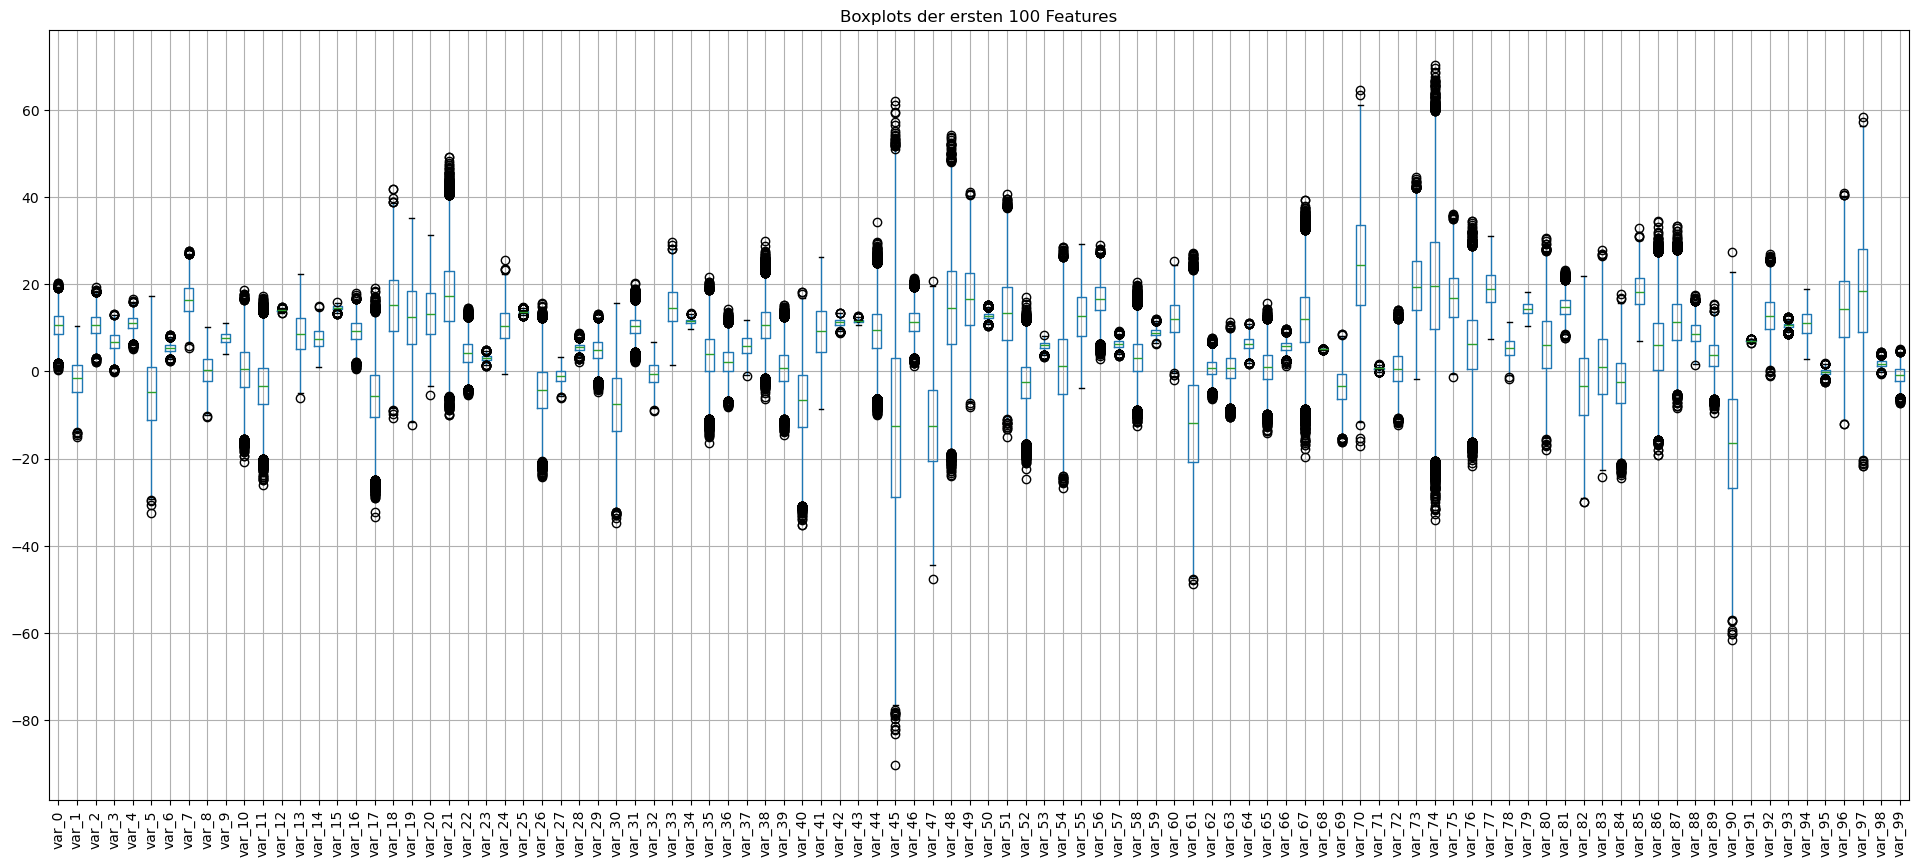

In [18]:
input_cols = [col for col in train.columns if col not in ['ID_code', 'target']]

# Boxplot der ersten 100 Features
train[input_cols[:100]].boxplot(figsize=(24,10))
plt.title("Boxplots der ersten 100 Features")
plt.xticks(rotation=90) 
plt.show()

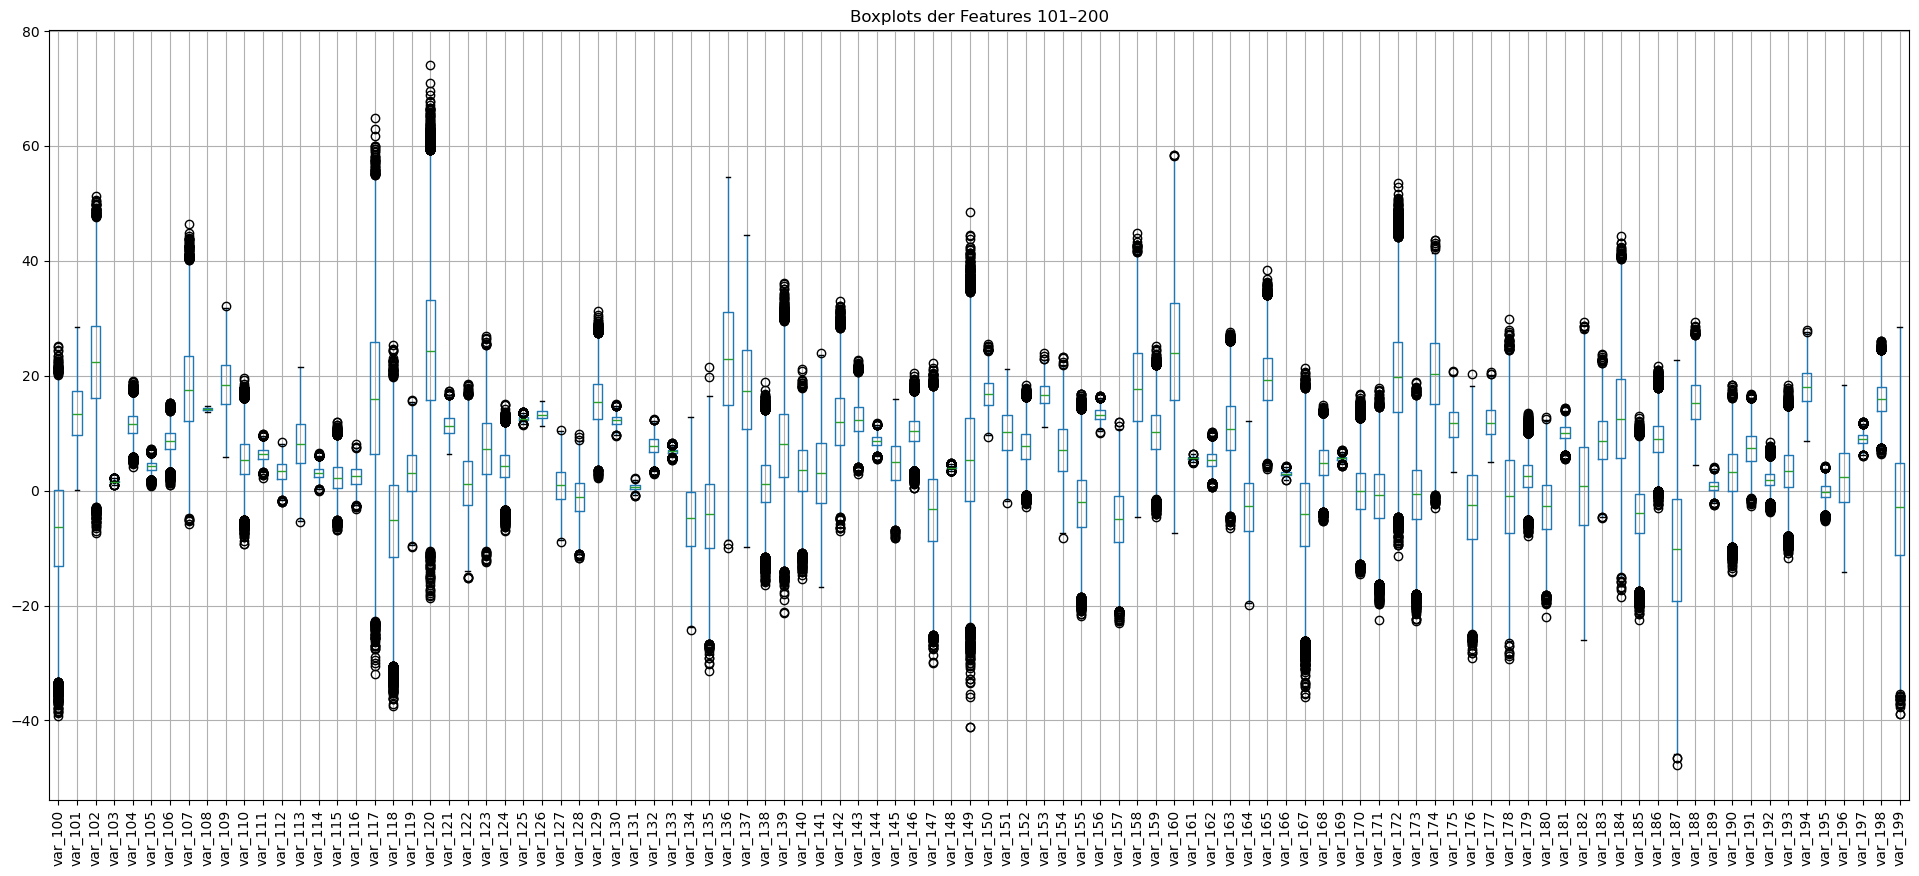

In [19]:
# Boxplot der nächsten 100 Features (Features 101 bis 200)
train[input_cols[100:200]].boxplot(figsize=(24,10))
plt.title("Boxplots der Features 101–200")
plt.xticks(rotation=90)
plt.show()


In [46]:
# unterschiedliche Skalas -> deshalb entweder skalierung oder standarisierung 

In [47]:
#💡 Da dein Santander-Datensatz 200 numerische Features mit sehr unterschiedlichen Skalen hat,
#würde ich fast immer Standardisierung empfehlen, wenn du Modelle wie logistische Regression, SVM oder neuronale Netze nutzt.
#Nur wenn du ein Modell wie Tree-Algorithmen (z. B. Random Forest, XGBoost, LightGBM) nimmst, kannst du dir das Skalieren sparen – die sind skaleninvariant

## Korrelation zwischen den Features

In [17]:
# Nur Feature-Spalten ohne ID und Target
input_cols = [col for col in train.columns if col not in ['ID_code', 'target']]

# 1️⃣ Pearson-Korrelation (linearer Zusammenhang)
pearson_corr = train[input_cols + ['target']].corr(method='pearson')['target'].drop('target')
pearson_corr = pearson_corr.sort_values(ascending=False)
print("Top 10 Features (Pearson):")
print(pearson_corr.head(10))

# 2️⃣ Spearman-Korrelation (monotoner Zusammenhang, robuster gegen Ausreißer)
spearman_corr = train[input_cols + ['target']].corr(method='spearman')['target'].drop('target')
spearman_corr = spearman_corr.sort_values(ascending=False)
print("\nTop 10 Features (Spearman):")
print(spearman_corr.head(20))

pearson_corr.to_csv("pearson_corr.csv")
spearman_corr.to_csv("spearman_corr.csv")

Top 10 Features (Pearson):
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
var_22     0.060558
var_99     0.058367
var_190    0.055973
var_2      0.055870
var_133    0.054548
var_0      0.052390
Name: target, dtype: float64

Top 10 Features (Spearman):
var_6      0.062429
var_110    0.058467
var_53     0.056951
var_26     0.055036
var_22     0.054424
var_99     0.053264
var_190    0.052389
var_2      0.050088
var_133    0.049213
var_0      0.046713
var_1      0.046202
var_40     0.045587
var_184    0.044844
var_78     0.044090
var_67     0.043291
var_179    0.042659
var_170    0.042590
var_191    0.042567
var_94     0.042387
var_173    0.040186
Name: target, dtype: float64


In [49]:
# Die Korrelationen sind sehr klein (maximal ca. 0.066 bei Pearson).
#→ Das bedeutet: Kein einzelnes Feature hängt stark linear mit der Zielvariable (target) zusammen.
#Beispiel:
#var_6 ist mit ca. 0.066 das am stärksten linear korrelierte Feature,
#danach folgen var_110, var_53, var_26 usw.
#→ Diese Werte sind aber immer noch sehr nahe bei 0, was zeigt, dass die Trenninformation wahrscheinlich nur in Kombination vieler Features steckt (typisch für Santander).
#Pearson vs. Spearman:
#Wenn Spearman ähnliche Werte liefert wie Pearson, heißt das, dass auch keine starken nichtlinearen-monotonen Zusammenhänge vorliegen.
#Falls Spearman deutlich höhere Werte hätte, würde das auf nichtlineare, aber monotone Zusammenhänge hindeuten.

## Prüfung auf Normalverteilung

In [32]:
batch_size = 10

with PdfPages("histograms_batches.pdf") as pdf:
    for start in range(0, len(input_cols), batch_size):
        batch_cols = input_cols[start:start+batch_size]
        plt.figure(figsize=(20, 10))
        
        for i, col in enumerate(batch_cols, 1):
            plt.subplot(2, 5, i)  # 2 Reihen, 5 Spalten Layout
            sns.histplot(train[col], kde=True, bins=30, color="skyblue")
            plt.title(col)
            plt.xlabel("Wert")
            plt.ylabel("Häufigkeit")
        
        plt.tight_layout()
        pdf.savefig()   # 🔹 Speichern diese Seite im PDF
        plt.close()



In [50]:
#Ja, diese Features sehen annähernd normalverteilt aus, und zwar aus diesen fünf Gründen:
#Glockenform → Die Histogramme zeigen eine symmetrische, glockenförmige Kurve, die typisch für eine Normalverteilung ist.
#Symmetrie um den Mittelwert → Die Häufigkeiten links und rechts vom Zentrum sind ungefähr gleich verteilt.
#Ein Peak → Es gibt nur einen zentralen Gipfel (Modus), keine Mehrgipfeligkeit.
#Abnehmende Häufigkeit zu den Rändern → Die Werte treten nahe dem Mittelwert am häufigsten auf, und je weiter man davon entfernt ist, desto seltener werden sie.
#KDE-Kurve passt zur Normalform → Die glatte Linie (Kernel Density Estimation) folgt fast perfekt der typischen Form einer Normalverteilung.
#Wenn du willst, kann ich dir noch einen statistischen Test (Shapiro-Wilk oder Kolmogorov-Smirnov) zeigen, um es objektiv zu überprüfen.

In [18]:
batch_size = 10

for start in range(0, len(input_cols), batch_size):
    batch_cols = input_cols[start:start+batch_size]
    plt.figure(figsize=(20, 10))
    
    for i, col in enumerate(batch_cols, 1):
        plt.subplot(2, 5, i)  # 2 Reihen, 5 Spalten Layout
        sns.histplot(train[col], kde=True, bins=30, color="skyblue")
        plt.title(col)
        plt.xlabel("Wert")
        plt.ylabel("Häufigkeit")
    
    plt.tight_layout()
    
    # 🔹 Speichern بدل show
    filename = f"hist_batch_{start//batch_size + 1}.png"
    plt.savefig(filename, bbox_inches="tight")
    plt.close()  # يغلق الشكل حتى ما يستهلك الميموري


# ScatterPlots

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Nur Features ohne ID/target
input_cols = [c for c in train.columns if c not in ['ID_code', 'target']]

# 1. Standardisieren (wichtig für PCA)
X_scaled = StandardScaler().fit_transform(train[input_cols])

# 2. PCA mit 2 Komponenten
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train['target'], cmap='coolwarm', alpha=0.5)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA (2 Komponenten)")
plt.colorbar(label='Target')
plt.savefig("pca_plot.png", bbox_inches="tight")
plt.close()





# Heatmaps

In [53]:
## Wir haben die Heatmap gemacht für alle  
# Dieses zeigt, dass wir zwischen den Variabeln nur sehr sehr geringe Korrelation haben. Die Farbe ist hell grau

In [20]:
from matplotlib.backends.backend_pdf import PdfPages

input_cols = [c for c in train.columns if c not in ['ID_code', 'target']]
rng = np.random.default_rng(123)

n_heatmaps = 20   
k = 30            

# 🔹 PDF öffnen einmal
with PdfPages("random_heatmaps.pdf") as pdf:
    for i in range(1, n_heatmaps + 1):
        cols = rng.choice(input_cols, size=min(k, len(input_cols)), replace=False)
        corr = train[list(cols)].corr()
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, cbar=True)
        plt.title(f"Random Feature Heatmap #{i} (n={len(cols)})")
        plt.tight_layout()
        
        # 🔹 Save aktuelle Figure in PDF
        pdf.savefig()
        plt.close()



In [55]:
##Zufällige unabhängige Ziehung (mit möglicher Wiederholung)
#Du bestimmst selbst, wie viele Heatmaps du haben möchtest.
#Jede Heatmap nimmt eine neue zufällige Stichprobe von 30 Features.
#Dabei ist es möglich, dass einige Features in mehreren Heatmaps vorkommen.
#Das kann sogar nützlich sein, weil du so überprüfen kannst, ob sich bestimmte Muster in verschiedenen Stichproben wiederholen.

In [ ]:
##### wir machen heatmaps für die wichtigesten Varaibeln, um zu wissen, ob sie unterschiedliche Informationen liefern 
## oder sie gleiche Information lieferen und wir auf manche verzichten können
## Es gibt keine Korrealtion zwischen den top 10 Features 

In [ ]:
#هاي الأقوى لبيانات Santander، لأنها بتفرجي تأثير كل Feature على قرار الموديل حتى لو الفرق كتير صغير.
#Dimensionality Reduction (PCA / t-SNE / UMAP):
بدل ما تشوفي عمودين فقط، بتسقطي البيانات كلها على #2D وتشوفي إذا في Clusterات بين Target=0 و Target=1.

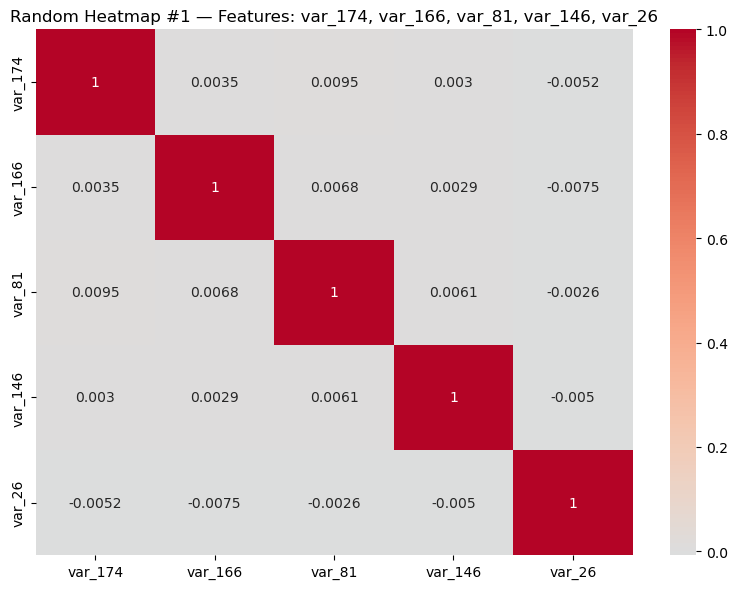

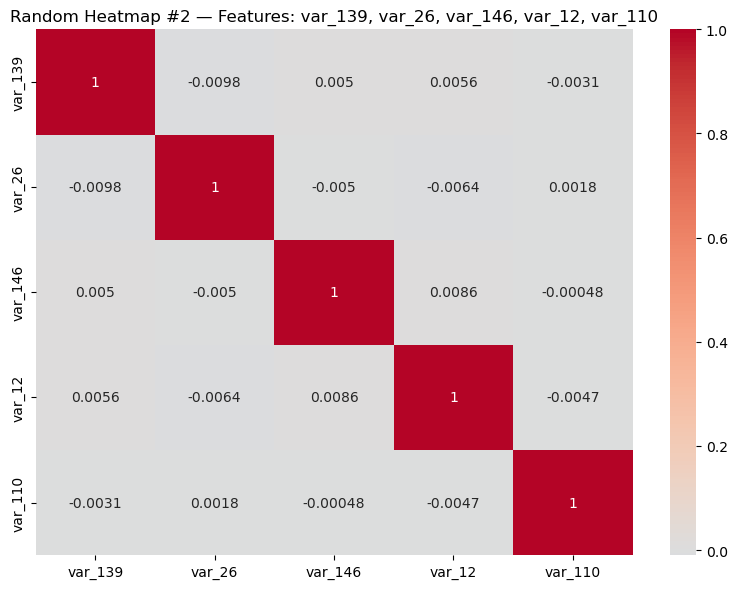

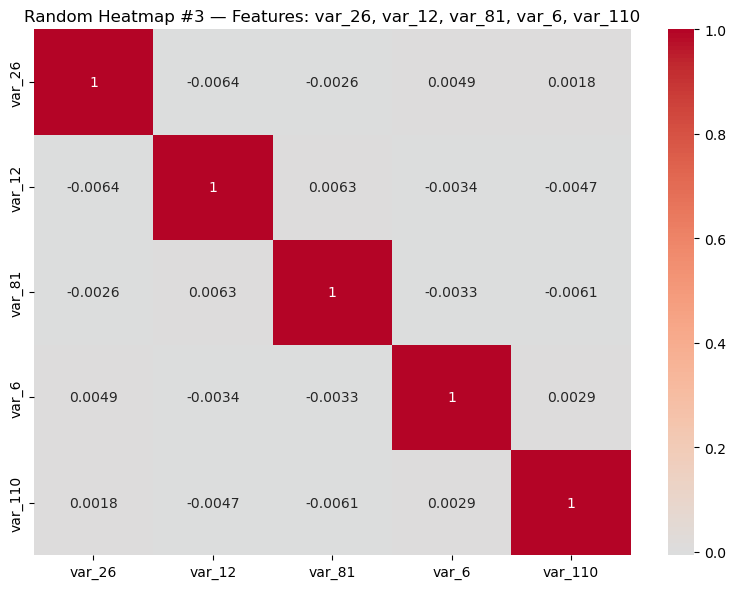

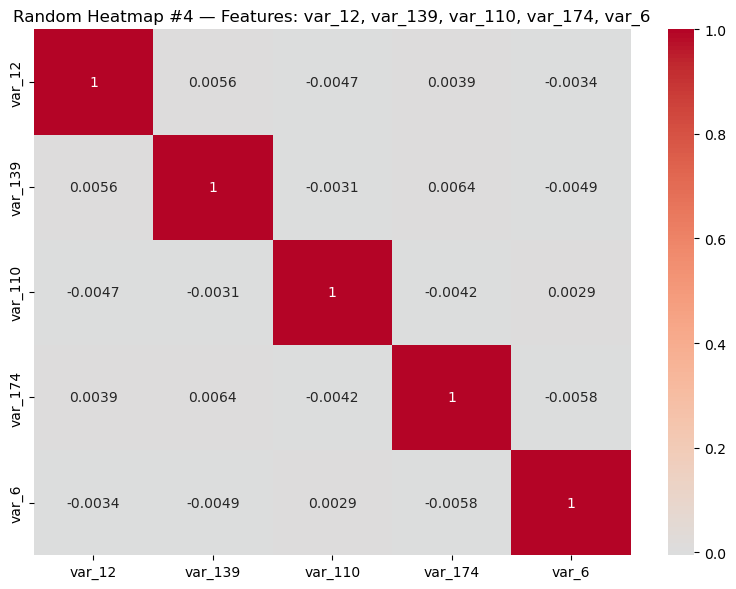

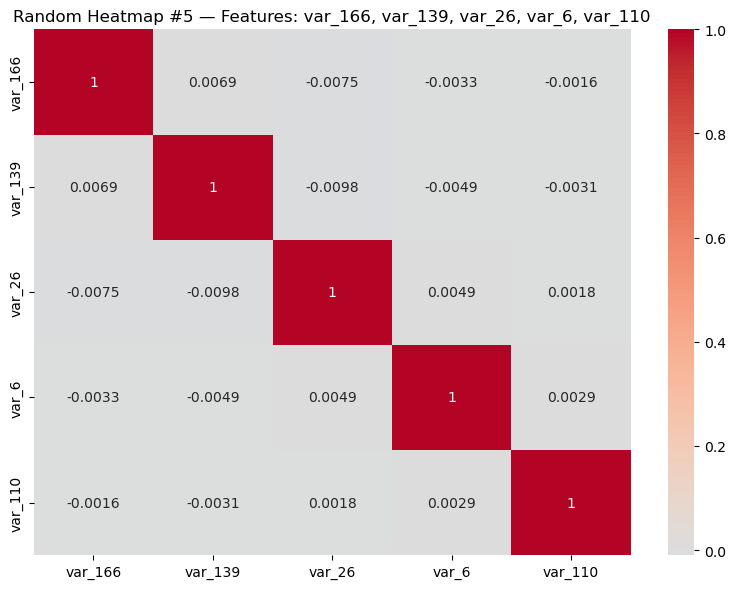

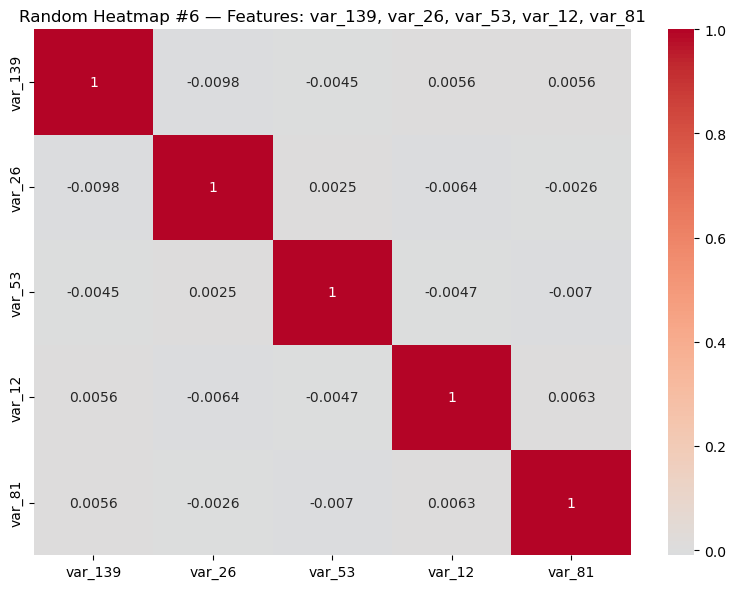

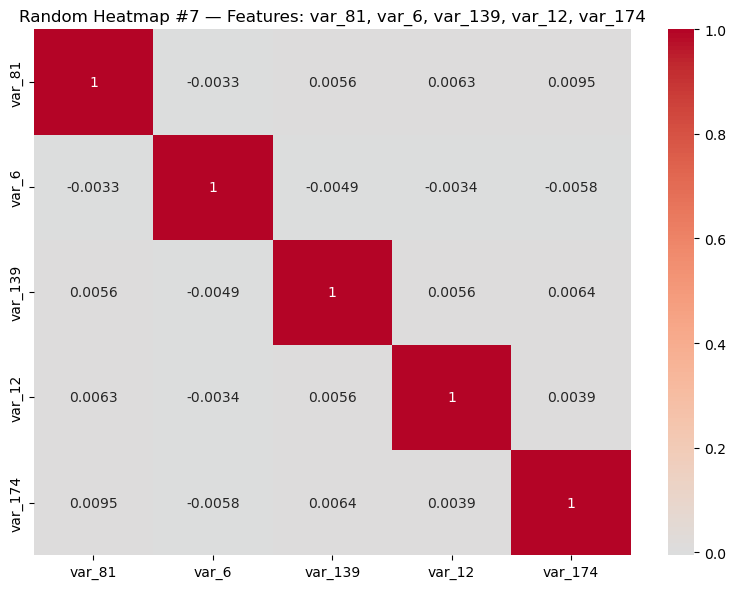

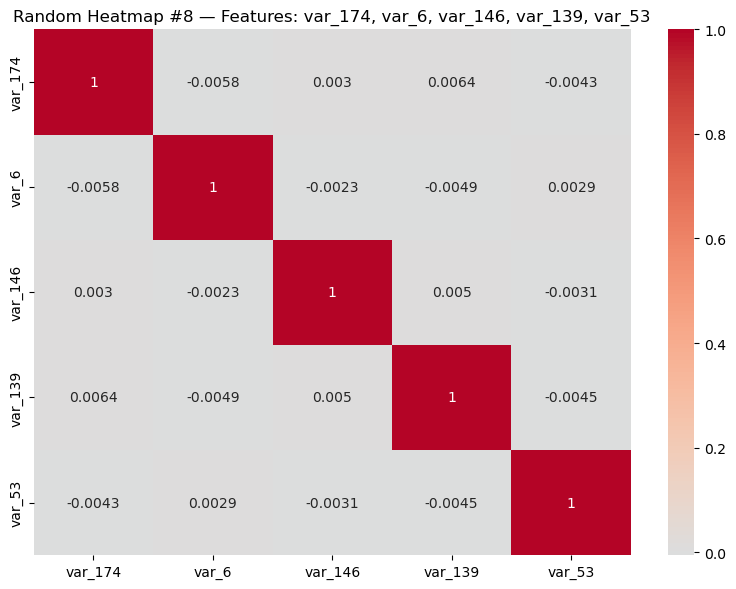

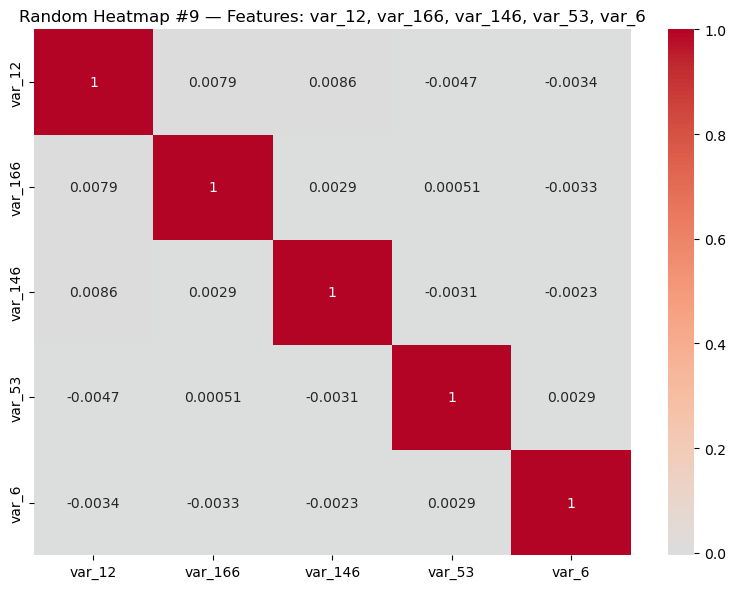

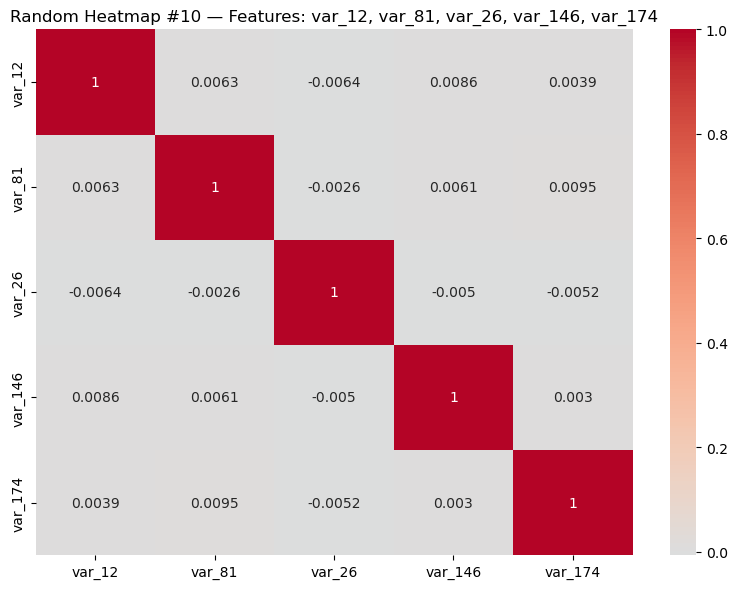

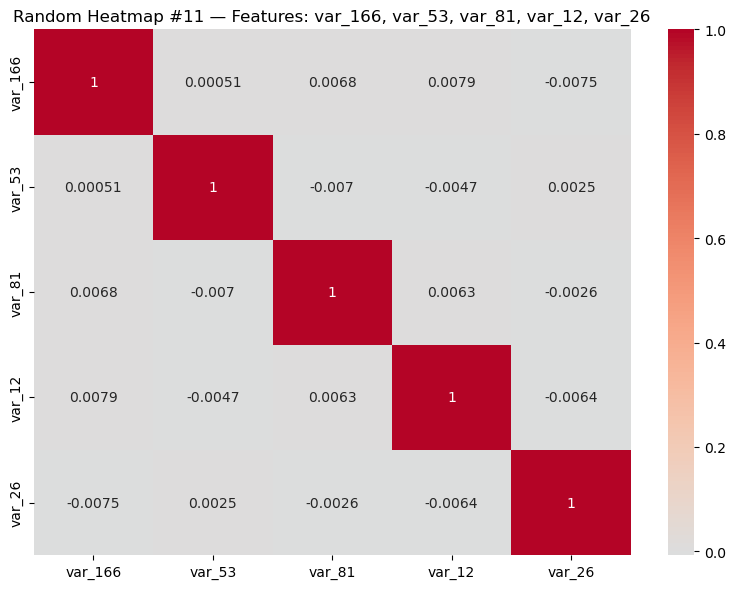

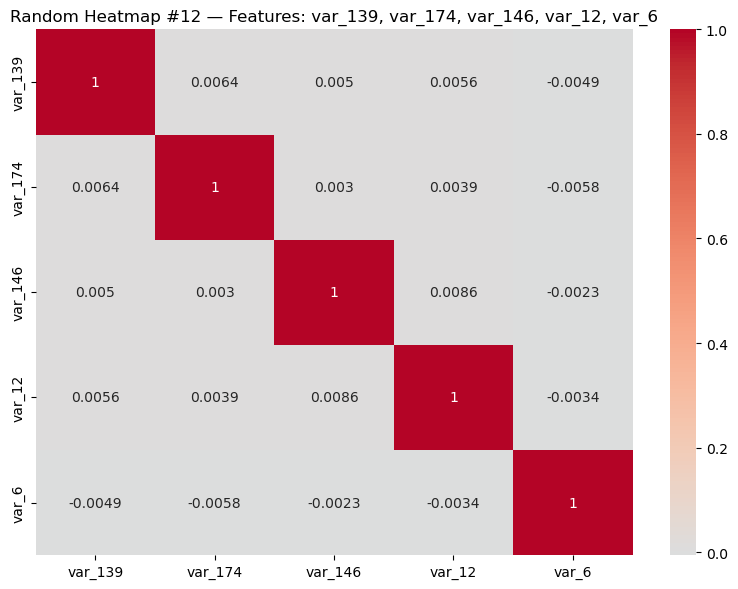

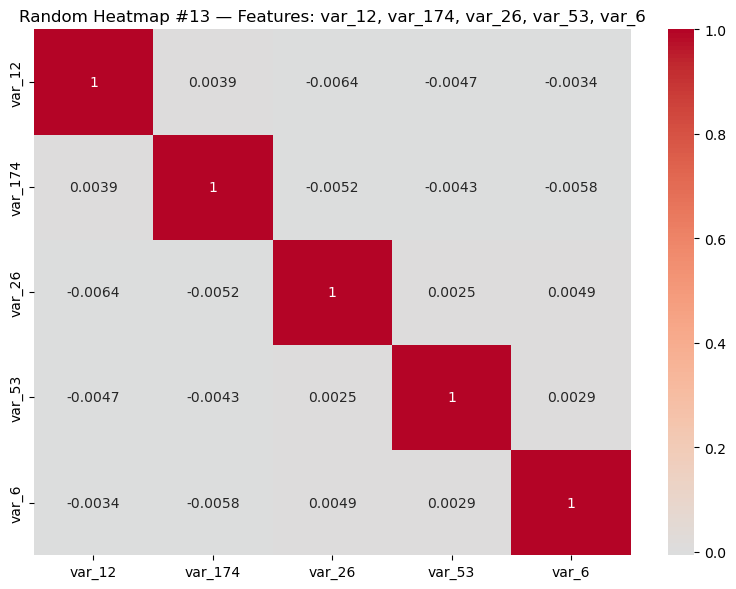

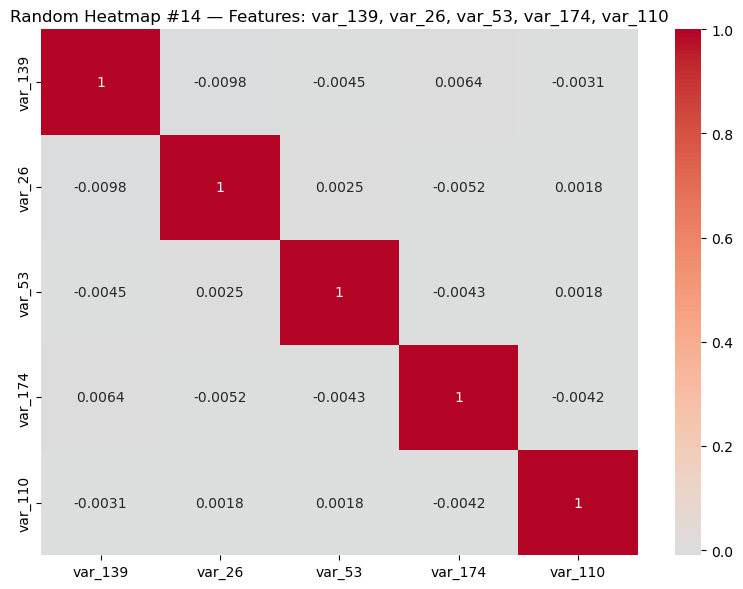

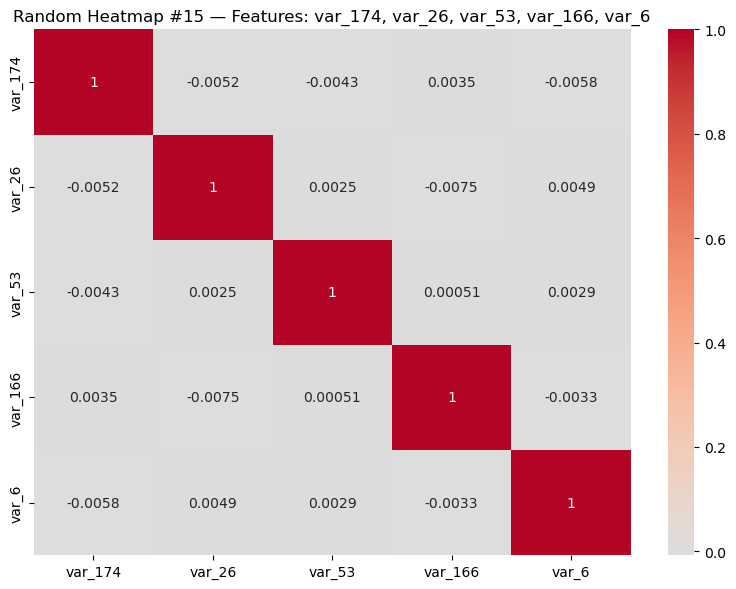

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# هدول هن الـ Top 10 Features يلي عطيتني ياهم
top_feats_10 = ["var_81", "var_139", "var_12", "var_53", "var_26",
                "var_6", "var_110", "var_166", "var_174", "var_146"]

rng = np.random.default_rng(123)

n_heatmaps = 15   # عدد الـ Heatmaps يلي بدك ترسمها
k = 5             # كم Feature بكل Heatmap (ممكن تغيرها لـ 3 أو 4)

for i in range(1, n_heatmaps + 1):
    cols = rng.choice(top_feats_10, size=min(k, len(top_feats_10)), replace=False)
    corr = train[list(cols)].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=True, cbar=True)
    plt.title(f"Random Heatmap #{i} — Features: {', '.join(cols)}")
    plt.tight_layout()
    plt.show()



with PdfPages("top_features_heatmaps.pdf") as pdf:
    for i in range(1, n_heatmaps + 1):
        cols = rng.choice(top_feats_10, size=min(k, len(top_feats_10)), replace=False)
        corr = train[list(cols)].corr()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, cmap="coolwarm", center=0, annot=True, cbar=True)
        plt.title(f"Random Heatmap #{i} — Features: {', '.join(cols)}")
        plt.tight_layout()
        
        pdf.savefig()   # 🔹 speichern in PDF
        plt.close()


## wichtige Features entdecken mit ML Modelle

# Random Forest

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

X = train.drop(['ID_code','target'], axis=1)
y = train['target']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, n_jobs=-1, class_weight='balanced', random_state=42
)
rf.fit(X_tr, y_tr)
print("AUC:", roc_auc_score(y_te, rf.predict_proba(X_te)[:,1]))

imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)



from joblib import dump

dump(rf, "rf_model.joblib")





AUC: 0.8274321762504875


['rf_model.joblib']

In [23]:
from joblib import load
rf_loaded = load("rf_model.joblib")

In [24]:
import pandas as pd

# اقرأ البيانات
train = pd.read_csv("train.csv")

# جهّزي الـ features (من غير ID_code و target)
X = train.drop(['ID_code','target'], axis=1)

# الآن بتقدري تعملي:
imp = pd.Series(rf_loaded.feature_importances_, index=X.columns).sort_values(ascending=False)
print(imp.head(20))



var_81     0.017106
var_139    0.015085
var_12     0.011889
var_110    0.010871
var_26     0.010290
var_6      0.010256
var_53     0.010216
var_146    0.010101
var_174    0.009481
var_22     0.009332
var_109    0.009165
var_166    0.008728
var_76     0.008610
var_190    0.008138
var_133    0.007874
var_80     0.007836
var_21     0.007666
var_99     0.007609
var_148    0.007504
var_2      0.007500
dtype: float64


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# أفضل 20 Feature (من اللي طلعوا عندك)
top_features = [
    "var_81","var_139","var_12","var_110","var_26",
    "var_6","var_53","var_146","var_174","var_22",
    "var_109","var_166","var_76","var_190","var_133",
    "var_80","var_21","var_99","var_148","var_2"
]

# اختيار فقط الـ top features
X = train[top_features]
y = train["target"]

# تقسيم للتدريب والتقييم
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# بناء النموذج
rf_top = RandomForestClassifier(
    n_estimators=400, max_depth=None, n_jobs=-1,
    class_weight="balanced", random_state=42
)
rf_top.fit(X_tr, y_tr)

# التقييم
print("AUC:", roc_auc_score(y_te, rf_top.predict_proba(X_te)[:,1]))

# حفظ النموذج الجديد
from joblib import dump
dump(rf_top, "rf_model_top20.joblib")



AUC: 0.7436205921476553


['rf_model_top20.joblib']

In [21]:
from joblib import load

rf_top_loaded = load("rf_model_top20.joblib")

imp_top = pd.Series(rf_top_loaded.feature_importances_, index=top_features).sort_values(ascending=False)
print(imp_top)


var_81     0.060390
var_139    0.057495
var_12     0.053543
var_110    0.051593
var_26     0.051009
var_53     0.050724
var_6      0.050565
var_146    0.050125
var_174    0.049762
var_22     0.049399
var_109    0.049045
var_76     0.048444
var_166    0.048055
var_190    0.047565
var_21     0.047406
var_80     0.047170
var_133    0.047124
var_99     0.046971
var_2      0.046857
var_148    0.046758
dtype: float64


In [22]:
# 1) لو لسه ما عندك train محمّل:
# import pandas as pd
# train = pd.read_csv("train.csv")

# 2) قائمة أهم 20 (من نتيجتك السابقة) – سنأخذ أول 10 منها:
top_features_20 = [
    "var_81","var_139","var_12","var_110","var_26",
    "var_53","var_6","var_146","var_174","var_22",
    "var_109","var_166","var_76","var_190","var_133",
    "var_21","var_80","var_99","var_2","var_148"
]
top10 = top_features_20[:10]
print("Top 10 features:", top10)

# 3) بيانات التدريب بهذه الأعمدة فقط
X = train[top10]
y = train["target"]

# 4) تقسيم وتدريب وتقييم
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf_top10 = RandomForestClassifier(
    n_estimators=400, max_depth=None, n_jobs=-1,
    class_weight="balanced", random_state=42
)
rf_top10.fit(X_tr, y_tr)

auc10 = roc_auc_score(y_te, rf_top10.predict_proba(X_te)[:, 1])
print("AUC (Top 10):", auc10)

# 5) نحفظ الموديل
from joblib import dump
dump(rf_top10, "rf_model_top10.joblib")


Top 10 features: ['var_81', 'var_139', 'var_12', 'var_110', 'var_26', 'var_53', 'var_6', 'var_146', 'var_174', 'var_22']
AUC (Top 10): 0.6883456501538998


['rf_model_top10.joblib']

In [ ]:
# 🔹 class_weight='balanced'
#إذا عندك البيانات غير متوازنة (مثلاً: 90% Target=0 و 10% Target=1)، النموذج ممكن يتعلم يختار دائمًا "0" ويجيب دقة عالية ظاهريًا.
#لما نكتب balanced → الخوارزمية تعطي وزن أكبر للفئة النادرة (1) عشان ما تتجاهلها.
#لو ما كتبنا balanced → النموذج يميل للفئة الكبيرة (الأكثر عددًا) ويتجاهل الفئة الصغيرة.

In [ ]:
#كيف Random Forest بيساعدك تعرف الميزات المهمة؟
#الغابة العشوائية (Random Forest) بتتكوّن من عدد كبير من أشجار القرار.
#كل شجرة بتختار ميزات مختلفة بالانقسامات (splits) عشان تحسّن التنبؤ.
#الميزة اللي بتستعملها الشجرة كثير وبشكل فعّال لفصل البيانات → معناها مؤثرة.

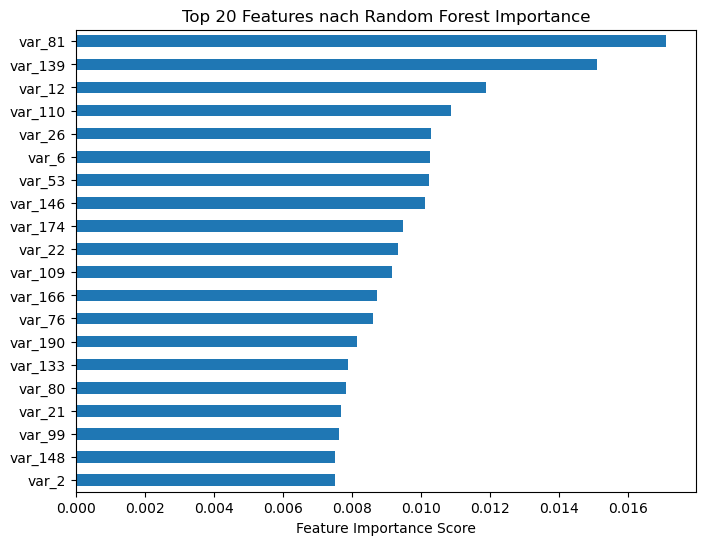

In [25]:
imp.head(20).plot(kind='barh', figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Top 20 Features nach Random Forest Importance")
plt.xlabel("Feature Importance Score")

# 🔹 Speichern als PNG
plt.savefig("rf_top20_importance.png", bbox_inches="tight", dpi=300)

plt.show()


In [ ]:
# 🔹 Wann du sie weglassen kannst:
#Modellvereinfachung → Weniger Features = schnelleres Training.
#Overfitting reduzieren → unwichtige Features können Rauschen bringen.
#Wenn du ein Modell willst, das interpretierbarer ist.

# Für die Modelle, die lange dauern, können wir Features, die die gleiche importance haben (wie von 133 bis 2), weg lassen, damit
# Training schneller erfolgt und wir vermeiden dadurch overfitting 
# ansonsten können wir für die andere Modelle alle Features nutzen, um die Genauigkeit zu behalten, aber wenn die features nicht balanciert sind
# könnte es sein, dass wir unter Rauschen leiden



In [ ]:
#شو بيعمل الكود؟
#permutation_importance: هاي الدالة بتقيس أهمية كل ميزة (Feature) بالنموذج عن طريق إعادة خلط (تبديل/Permutation) قيم هاي الميزة.
#الفكرة:
#إذا الميزة مهمة، ولخبطنا قيمها، أداء النموذج رح يسوء بشكل واضح.
#إذا الميزة مش مهمة، حتى لو لخبطنا قيمها، الأداء ما بيتأثر كتير.
#n_repeats=5: يعني بيكرر عملية الخلط 5 مرات عشان يضمن نتائج مستقرة.
#scoring='roc_auc': مقياس الأداء هون هو الـ AUC (منحنى ROC).
#بالآخر بيحسب متوسط التغير بالأداء لكل ميزة (perm.importances_mean).
#الكود بيرتب الميزات حسب أهميتها وبيطبع أعلى 20 ميزة.

# Permutation Importance 

In [26]:
#2 Permutation Importance (أدق من “Gini” لأنه مبني على الأداء)



from sklearn.inspection import permutation_importance

perm = permutation_importance(rf, X_te, y_te, n_repeats=3, random_state=42, scoring='roc_auc')
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
print(perm_imp.head(20))

perm_imp_df = perm_imp.reset_index()
perm_imp_df.columns = ["Feature", "Importance"]

# حفظ الملف
perm_imp_df.to_csv("perm_importance.csv", index=False)


var_81     0.016811
var_139    0.013330
var_12     0.011093
var_26     0.008900
var_110    0.007859
var_53     0.007457
var_6      0.006648
var_146    0.006459
var_174    0.005955
var_166    0.005678
var_22     0.004940
var_109    0.004868
var_80     0.004825
var_99     0.004496
var_78     0.004251
var_21     0.003879
var_76     0.003816
var_133    0.003809
var_44     0.003742
var_190    0.003641
dtype: float64


## Scatter Plots 

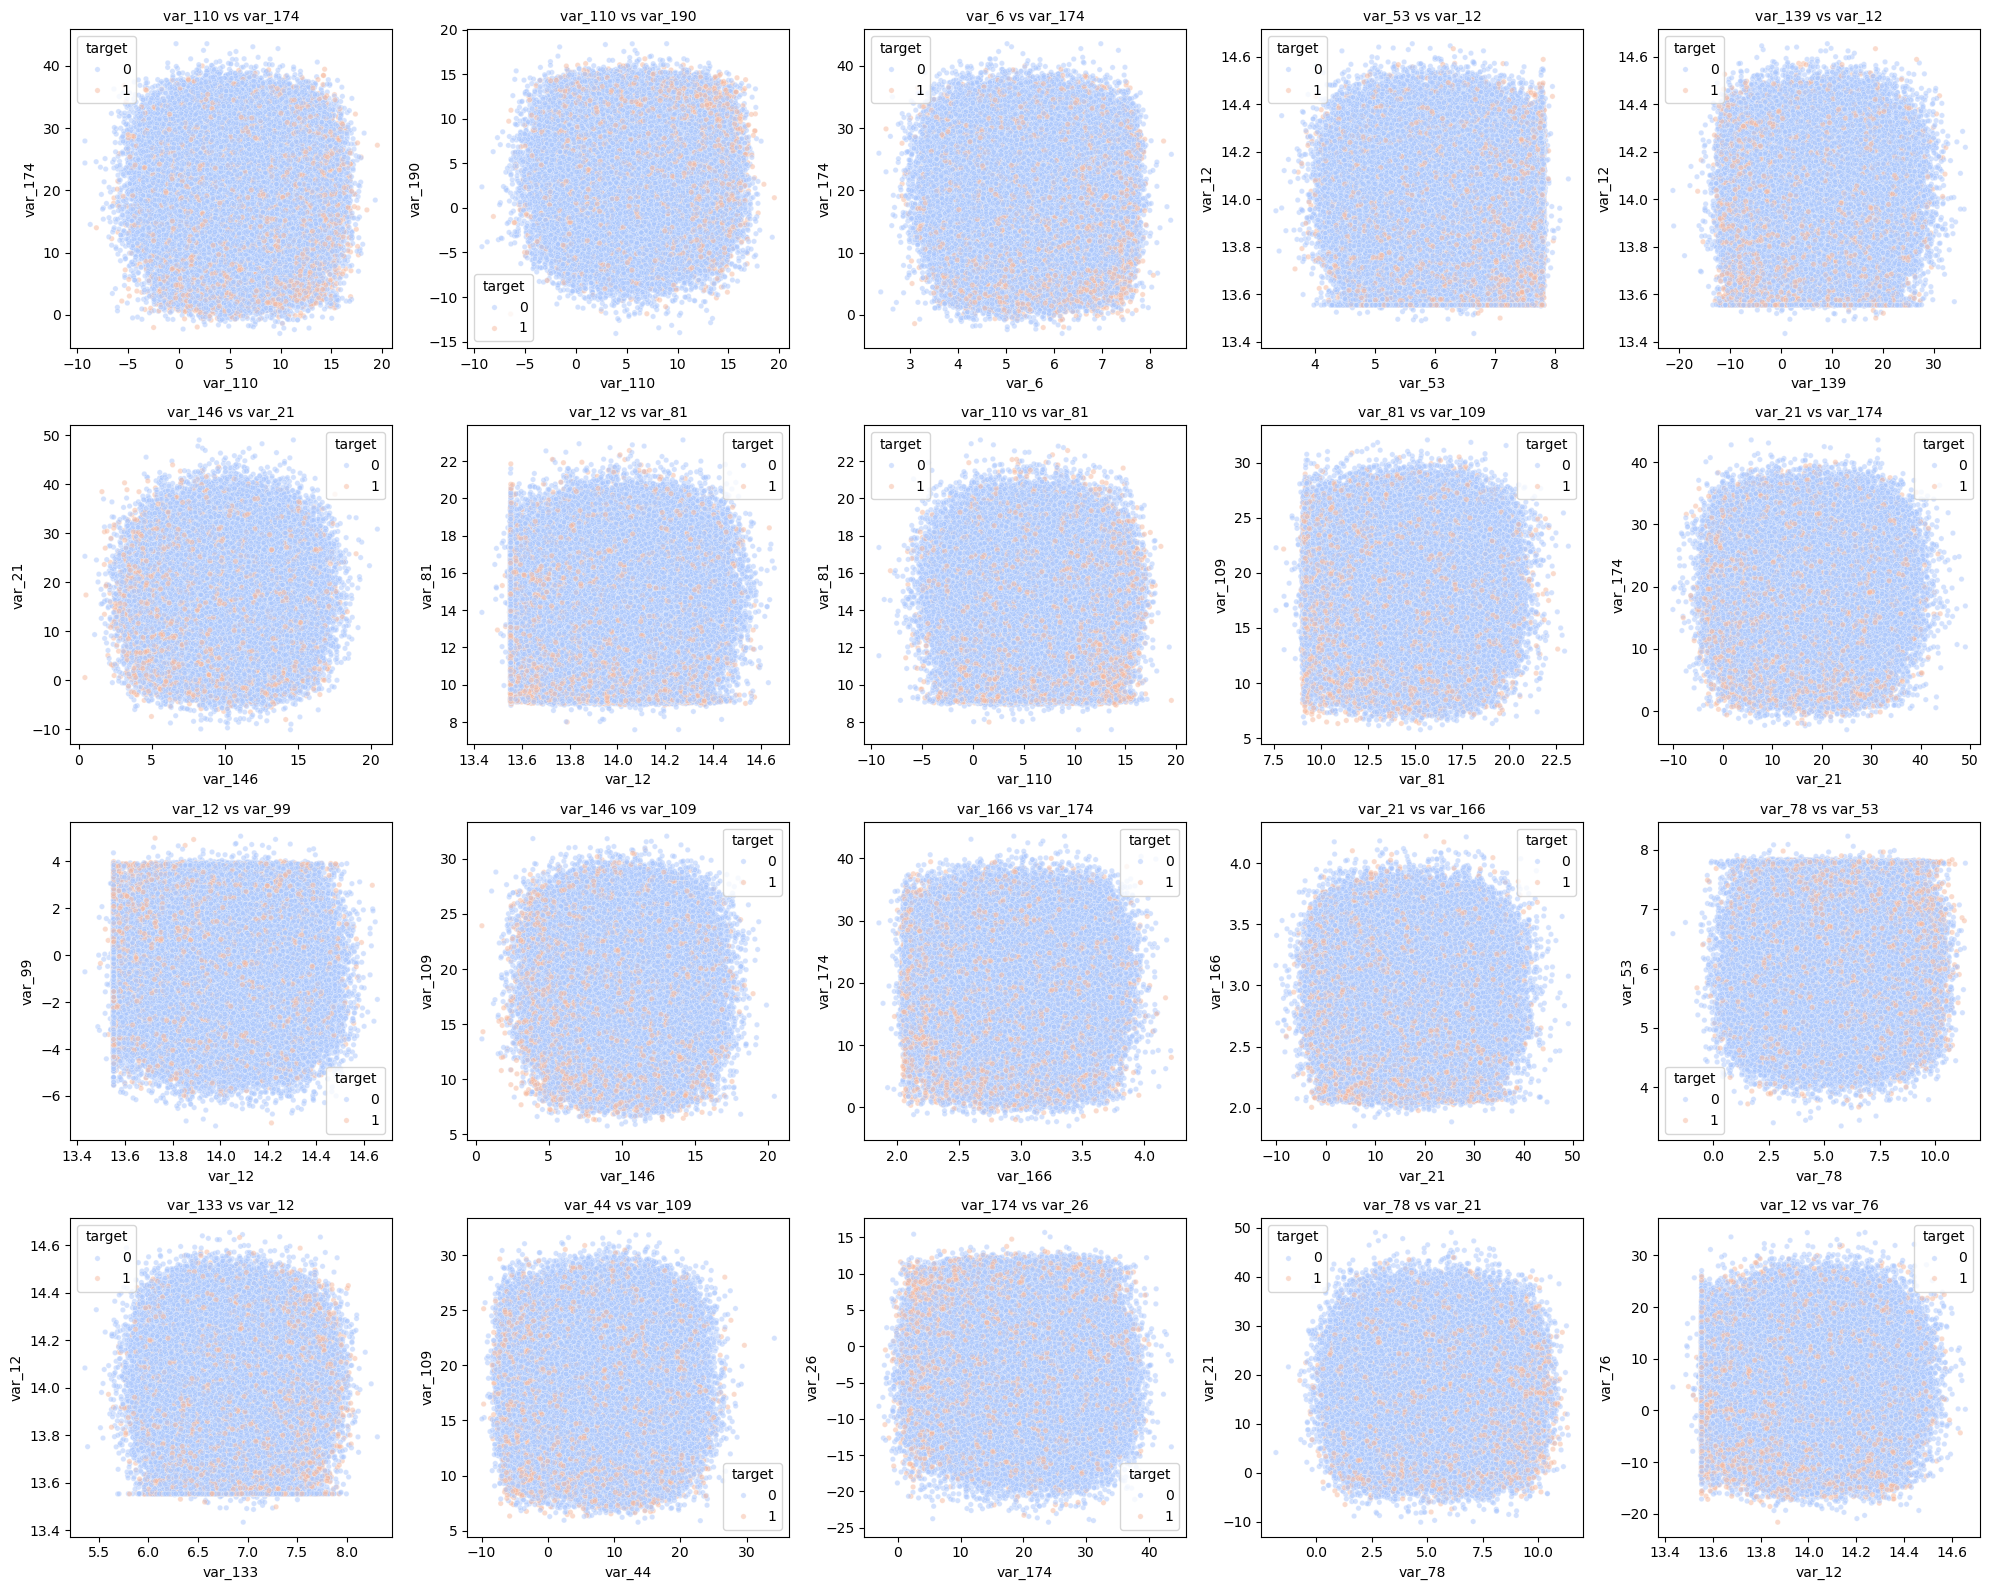

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# أهم 20 Feature حسب Permutation Importance
top_features_perm = [
    "var_81","var_139","var_12","var_26","var_110",
    "var_53","var_6","var_146","var_174","var_166",
    "var_22","var_109","var_80","var_99","var_78",
    "var_21","var_76","var_133","var_44","var_190"
]

# نولّد 20 زوج عشوائي (بدون تكرار لنفس الزوج)
np.random.seed(123)
pairs = set()
while len(pairs) < 20:
    f1, f2 = np.random.choice(top_features_perm, 2, replace=False)
    if (f2, f1) not in pairs:  # نتأكد ما نكرر نفس الزوج بالعكس
        pairs.add((f1, f2))
pairs = list(pairs)

# رسم 20 Scatter Plot (4 × 5 Grid)
plt.figure(figsize=(20, 16))
for i, (f1, f2) in enumerate(pairs, 1):
    plt.subplot(4, 5, i)
    sns.scatterplot(
        x=train[f1], y=train[f2],
        hue=train["target"], palette="coolwarm",
        alpha=0.5, s=15
    )
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f"{f1} vs {f2}", fontsize=10)

plt.tight_layout()

# 🔹 حفظ الصورة بدقة عالية
plt.savefig("scatter_pairs_perm_top20.png", bbox_inches="tight", dpi=300)

plt.show()

In [29]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# 1) Mutual Information
mi = mutual_info_classif(X, y, random_state=42, n_neighbors=5)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

# 2) حفظ النتائج كـ CSV
mi_series.to_csv("mutual_info_results.csv", header=True)

# 3) قراءة النتائج لاحقًا
mi_loaded = pd.read_csv("mutual_info_results.csv", index_col=0)

print(mi_loaded.head(20))


                0
var_81   0.004835
var_12   0.003809
var_80   0.003711
var_139  0.003372
var_26   0.003264
var_110  0.002765
var_165  0.002649
var_166  0.002604
var_99   0.002560
var_190  0.002508
var_174  0.002465
var_6    0.002287
var_146  0.002278
var_109  0.002256
var_164  0.002248
var_191  0.002189
var_34   0.002142
var_44   0.002086
var_92   0.002075
var_22   0.002052


In [ ]:
# noch zu machen XGBoost und Logistische Regression 

In [30]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import roc_auc_score

# حول الداتا إلى DMatrix
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dvalid = xgb.DMatrix(X_te, label=y_te)

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "seed": 42
}

# تدريب مع إيقاف مبكر
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=[(dvalid, "valid")],
    early_stopping_rounds=100
)

# احتمالات + AUC
proba = bst.predict(dvalid)                 # يعطي احتمالات مباشرة
print("AUC:", roc_auc_score(y_te, proba))

# أهم الميزات (gain)
imp = bst.get_score(importance_type="gain")
imp_df = pd.DataFrame(sorted(imp.items(), key=lambda x: x[1], reverse=True),
                      columns=["feature", "gain"])
print(imp_df.head(20))




import joblib

results = {
    "model": bst, 
    "feature_importance": imp_df,
    "proba": proba,
    "auc": roc_auc_score(y_te, proba)
}

joblib.dump(results, "xgb_results.pkl")

# لاحقًا
loaded = joblib.load("xgb_results.pkl")
print(loaded["auc"])
print(loaded["feature_importance"].head())



[0]	valid-auc:0.63305
[1]	valid-auc:0.66899
[2]	valid-auc:0.67850
[3]	valid-auc:0.68850
[4]	valid-auc:0.69601
[5]	valid-auc:0.70591
[6]	valid-auc:0.70653
[7]	valid-auc:0.71498
[8]	valid-auc:0.71790
[9]	valid-auc:0.71865
[10]	valid-auc:0.72137
[11]	valid-auc:0.72700
[12]	valid-auc:0.73242
[13]	valid-auc:0.73671
[14]	valid-auc:0.73956
[15]	valid-auc:0.74343
[16]	valid-auc:0.74562
[17]	valid-auc:0.74824
[18]	valid-auc:0.75191
[19]	valid-auc:0.75477
[20]	valid-auc:0.75857
[21]	valid-auc:0.76095
[22]	valid-auc:0.76393
[23]	valid-auc:0.76665
[24]	valid-auc:0.76921
[25]	valid-auc:0.77223
[26]	valid-auc:0.77465
[27]	valid-auc:0.77667
[28]	valid-auc:0.77713
[29]	valid-auc:0.78051
[30]	valid-auc:0.78198
[31]	valid-auc:0.78356
[32]	valid-auc:0.78494
[33]	valid-auc:0.78695
[34]	valid-auc:0.78757
[35]	valid-auc:0.78931
[36]	valid-auc:0.79066
[37]	valid-auc:0.79213
[38]	valid-auc:0.79340
[39]	valid-auc:0.79398
[40]	valid-auc:0.79512
[41]	valid-auc:0.79645
[42]	valid-auc:0.79811
[43]	valid-auc:0.7995

In [31]:
# من imp_df (اللي فيه feature, gain) نعمل Series
# xgb_imp = imp_df.set_index("feature")["gain"]

# استخراج feature importance من الملف المحمّل
xgb_imp = loaded["feature_importance"].set_index("feature")["gain"]

# مثال: اطبع أول 5
print(xgb_imp.head())


# أو إذا عندك dict مباشر من get_score:
# xgb_imp = pd.Series(imp)


In [ ]:
# wir haben die Ergebnisse drei Modellen verglichen und somit die besten 10 Features vergliechen
# 

## Model Vergleiche 
# Top Features 

In [34]:
import pandas as pd
import numpy as np

# ---- 1) حوّل كل نتيجة إلى Series باسم المؤشر = اسم العمود -------------------
def to_series(obj, feature_index=None, value_col=None):
    """
    يرجّع Series:
    - إذا obj Series --> يرجّعه كما هو
    - إذا obj DataFrame --> يأخذ العمود value_col ويجعله Series بمؤشر feature
    - إذا obj dict --> يحوّله Series مباشرة
    - إذا obj ndarray/ list --> يحتاج feature_index لتسمية العناصر
    """
    if isinstance(obj, pd.Series):
        return obj
    if isinstance(obj, pd.DataFrame):
        if value_col is None:
            raise ValueError("مرّر value_col لاستخراج عمود القيم من DataFrame.")
        s = obj[value_col]
        # لو في عمود لاسم الميزة اسمه 'feature' خلِّه كمؤشر
        if 'feature' in obj.columns and s.index.name != 'feature':
            s = s.set_axis(obj['feature'])
        return s
    if isinstance(obj, dict):
        return pd.Series(obj)
    # مصفوفة/قائمة
    if feature_index is None:
        raise ValueError("مرّر feature_index عندما تكون القيم array/list.")
    return pd.Series(obj, index=feature_index)

# RF: عندك imp جاهزة كسلسلة من قبل (feature_importances_)؛ إن لم تكن:
rf_imp_series = to_series(imp)  # imp من RF

# Permutation: عندك perm_imp جاهزة كسلسلة من قبل
perm_imp_series = to_series(perm_imp)  # perm.importances_mean

# XGBoost: لو عندك imp_df (feature, gain) أو imp (dict من get_score)
try:
    xgb_imp_series = to_series(imp_df, value_col="gain").rename("gain")
except NameError:
    # إذا ما عندك imp_df لكن عندك imp dict من bst.get_score(...)
    xgb_imp_series = to_series(imp)  # dict
    xgb_imp_series.name = "gain"

# ---- 2) وحِّد المؤشرات حتى تشمل كل الأعمدة الموجودة بأي نتيجة ---------------
all_feats = rf_imp_series.index.union(perm_imp_series.index).union(xgb_imp_series.index)

rf_imp_series   = rf_imp_series.reindex(all_feats)
perm_imp_series = perm_imp_series.reindex(all_feats)
xgb_imp_series  = xgb_imp_series.reindex(all_feats)

# ---- 3) احسب الرتب (بدون سالب) باستخدام ascending=False --------------------
ranks = pd.DataFrame({
    "rf_rank":   rf_imp_series.rank(ascending=False, method="average"),
    "perm_rank": perm_imp_series.rank(ascending=False, method="average"),
    "xgb_rank":  xgb_imp_series.rank(ascending=False, method="average"),
})

# للأعمدة اللي قيمتها NaN في معيار ما (ما ظهرت)، عطها رتبة سيئة كبيرة
big = len(all_feats) + 1
ranks = ranks.fillna(big)

# رتبة مجمّعة
ranks["mean_rank"] = ranks.mean(axis=1)

# ---- 4) استخرج القوائم ------------------------------------------------------
top50  = ranks.nsmallest(50, "mean_rank").index.tolist()
top100 = ranks.nsmallest(100, "mean_rank").index.tolist()

print("أفضل 10 ميزات بالترتيب المجمّع:")
print(ranks.sort_values("mean_rank").head(10))

ranks.to_csv("feature_ranks.csv", index=True)


أفضل 10 ميزات بالترتيب المجمّع:
         rf_rank  perm_rank  xgb_rank  mean_rank
var_81       1.0        1.0       1.0   1.000000
var_139      2.0        2.0       2.0   2.000000
var_12       3.0        3.0       3.0   3.000000
var_53       4.0        6.0       4.0   4.666667
var_26       5.0        4.0       5.0   4.666667
var_6        6.0        7.0       6.0   6.333333
var_110      7.0        5.0       7.0   6.333333
var_166      8.0       10.0       8.0   8.666667
var_174      9.0        9.0       9.0   9.000000
var_146     11.0        8.0      11.0  10.000000


In [36]:
# نعمل القوائم Top-K
top10   = ranks.nsmallest(10, "mean_rank").index.tolist()
top15   = ranks.nsmallest(15, "mean_rank").index.tolist()
top17   = ranks.nsmallest(17, "mean_rank").index.tolist()
top19   = ranks.nsmallest(19, "mean_rank").index.tolist()
top23   = ranks.nsmallest(23, "mean_rank").index.tolist()
top28   = ranks.nsmallest(28, "mean_rank").index.tolist()
top50   = ranks.nsmallest(50, "mean_rank").index.tolist()
top100  = ranks.nsmallest(100, "mean_rank").index.tolist()
top150  = ranks.nsmallest(150, "mean_rank").index.tolist()

print("عدد الأعمدة في كل قائمة:", len(top50), len(top100), len(top150))



# نجمع كل القوائم في dict
top_dict = {
    "Top10": top10,
    "Top15": top15,
    "Top17": top17,
    "Top19": top19,
    "Top23": top23,
    "Top28": top28,
    "Top50": top50,
    "Top100": top100,
    "Top150": top150,
}

# نبني DataFrame موحّد
rows = []
for name, feats in top_dict.items():
    for f in feats:
        rows.append({"feature": f, "in_top": name})

df_all = pd.DataFrame(rows).drop_duplicates()

# حفظ الملف
df_all.to_csv("top_features_all.csv", index=False)
print("تم الحفظ → top_features_all.csv")

عدد الأعمدة في كل قائمة: 50 100 150
تم الحفظ → top_features_all.csv


In [40]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np

def cv_auc_for_features(cols, model=None, cv_folds=5, random_state=42):
    if model is None:
        model = HistGradientBoostingClassifier(max_iter=300, learning_rate=0.1, random_state=random_state)
    X_sub = X[cols].astype(np.float32)        # خذ فقط الأعمدة المختارة
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    scores = cross_val_score(model, X_sub, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    return scores.mean(), scores.std()

sets = [("Top10", top10), ("Top15", top15), ("Top17", top17), ("Top19", top19), ("Top23", top23), ("Top28", top28), ("Top50", top50), ("Top100", top100), ("Top150", top150)]
for name, cols in sets:
    m, s = cv_auc_for_features(cols, cv_folds=5)
    print(f"{name:7s} | ROC-AUC = {m:.4f} ± {s:.4f}")
import pandas as pd

results = []

sets = [
    ("Top10", top10), ("Top15", top15), ("Top17", top17), ("Top19", top19),
    ("Top23", top23), ("Top28", top28), ("Top50", top50),
    ("Top100", top100), ("Top150", top150)
]

for name, cols in sets:
    m, s = cv_auc_for_features(cols, cv_folds=5)
    results.append({"set": name, "mean_auc": m, "std_auc": s})
    print(f"{name:7s} | ROC-AUC = {m:.4f} ± {s:.4f}")

# تحويل النتائج إلى DataFrame
results_df = pd.DataFrame(results)

# حفظ النتائج بعدة صيغ
results_df.to_csv("cv_auc_results.csv", index=False)
results_df.to_excel("cv_auc_results.xlsx", index=False)
results_df.to_pickle("cv_auc_results.pkl")

print("\nتم الحفظ في:")
print(" - cv_auc_results.csv")
print(" - cv_auc_results.xlsx")
print(" - cv_auc_results.pkl")



Top10   | ROC-AUC = 0.7097 ± 0.0054
Top15   | ROC-AUC = 0.7423 ± 0.0048
Top17   | ROC-AUC = 0.7515 ± 0.0047
Top19   | ROC-AUC = 0.7616 ± 0.0036
Top23   | ROC-AUC = 0.7775 ± 0.0040
Top28   | ROC-AUC = 0.7937 ± 0.0033
Top50   | ROC-AUC = 0.8395 ± 0.0039
Top100  | ROC-AUC = 0.8772 ± 0.0030
Top150  | ROC-AUC = 0.8853 ± 0.0030
Top10   | ROC-AUC = 0.7097 ± 0.0054
Top15   | ROC-AUC = 0.7423 ± 0.0048
Top17   | ROC-AUC = 0.7515 ± 0.0047
Top19   | ROC-AUC = 0.7616 ± 0.0036
Top23   | ROC-AUC = 0.7775 ± 0.0040
Top28   | ROC-AUC = 0.7937 ± 0.0033
Top50   | ROC-AUC = 0.8395 ± 0.0039
Top100  | ROC-AUC = 0.8772 ± 0.0030
Top150  | ROC-AUC = 0.8853 ± 0.0030

تم الحفظ في:
 - cv_auc_results.csv
 - cv_auc_results.xlsx
 - cv_auc_results.pkl


In [41]:
# اختر أفضل 15 ميزة حسب mean_rank
top20 = ranks.nsmallest(20, "mean_rank").index.tolist()
print("Top20 features:", top20)


Top20 features: ['var_81', 'var_139', 'var_12', 'var_26', 'var_53', 'var_110', 'var_6', 'var_166', 'var_174', 'var_146', 'var_80', 'var_22', 'var_109', 'var_76', 'var_99', 'var_2', 'var_44', 'var_133', 'var_190', 'var_21']


In [ ]:
####### WARP Methods 
#✅ شو معناها؟
#Wrapper methods: يعني بدال ما تطلع بس على إحصائيات الأعمدة، بتجرب فعليًا كل subset من الأعمدة وتدرّب عليه موديل.
#Exhaustive approach: يعني بيجرب كل التركيبات الممكنة من الأعمدة (1,2,3) أو (1,2,4,6) ... إلخ، ويحسب الأداء لكل مجموعة.
#وبالنهاية بيختار المجموعة اللي تعطي أفضل Score (مثل AUC).
#✅ علاقتها بشغلك:
#إنت ما مشيت بالضبط بهالطريقة "المتعبة" (لأنها غير عملية مع 200 عمود 👀).
#بدل هيك استعملت طرق تقدير الأهمية (RF importance, Permutation, XGBoost gain, MI) لتعمل ترتيب features.
#بعدين أخذت Top-K subsets (50, 100, 150) وجربت الأداء عليهم.

In [ ]:
#🔹 شو نستنتج:
#إضافة ميزات مهمة جديدة حسّنت الأداء: من 50 إلى 100 صار في قفزة كبيرة بالـ AUC.بعد الـ 100 ميزات، التحسن صار بسيط: من 100 إلى 150 زاد الأداء شوي صغير (0.877 → 0.885).
#أفضل نقطة توازن: غالبًا استخدام Top100 أو Top150 بيعطي أفضل أداء مستقر.
#لو بدك موديل أسرع وأبسط → Top100 كافي.
#لو بدك أعلى AUC ممكن (وما عندك مشكلة بالبطء) → Top150.

In [ ]:
# es gibt viele Anzahl an Probalitäten und je mehr die Anzahl der Bäume größer ist und Anzahl der (اوراق) größer, desto mehr Zeit bräuchten 
# wir können hier die Tiefe der Bäume fixieren (nachschauen nicht sicher)